### Import necessary libraries and custom modules

In [1]:
# Allows the import of Jupyter notebooks as Python modules
import import_ipynb

# Import custom Tennis Analysis Tools module
import Tennis_Analysis_Tools as tennis_tools

# Import numerical computing library for handling arrays and mathematical functions
import numpy as np

# Import pandas library for data manipulation and analysis
import pandas as pd

# Import matplotlib library for creating visualizations and plots
import matplotlib.pyplot as plt

importing Jupyter notebook from Tennis_Analysis_Tools.ipynb


### Function to preprocess the dataset

In [2]:
def preprocess_dataset(betting_data_dfs):
    
    """
    Prepares and cleans the betting data for analysis. This function filters the dataset to include only
    completed matches, cleans and converts ranking data, and creates a derived column to indicate if the
    higher-ranked player won the match. It concludes by selecting a subset of essential columns for further analysis.
    """
    
    # Filter the dataset to include only completed matches
    betting_data_dfs = betting_data_dfs[betting_data_dfs['Comment'].isin(['Completed'])]

    # Reset the index to ensure it's sequential after filtering
    betting_data_dfs.reset_index(drop=True, inplace=True)
       
    # Convert 'WRank' and 'LRank' columns to numeric, forcing errors to NaN
    betting_data_dfs['WRank'] = pd.to_numeric(betting_data_dfs['WRank'], errors='coerce')
    betting_data_dfs['LRank'] = pd.to_numeric(betting_data_dfs['LRank'], errors='coerce')

    # Fill NaN values in 'WRank' and 'LRank' with 100000 and convert to float
    betting_data_dfs['WRank'] = betting_data_dfs['WRank'].fillna(100000).astype(float)
    betting_data_dfs['LRank'] = betting_data_dfs['LRank'].fillna(100000).astype(float)

    # Create a column indicating if the higher-ranked player won (1 if true, 0 if false)
    betting_data_dfs['higher_rank_won'] = (
        betting_data_dfs['WRank'] < betting_data_dfs['LRank']
    ).astype(int)

    # Define the essential columns to keep in the dataframe
    essential_columns = ['Date', 'Surface', 'WRank', 'LRank', 
                         'higher_rank_won', 'Winner', 'Loser']

    # Filter the dataframe to keep only the essential columns
    betting_data_filtered = betting_data_dfs[essential_columns]

    # Return the preprocessed dataframe
    return betting_data_filtered

### Function related to ELO

In [3]:
def calculate_k(games_played, surface, delta=100, nu=5, sigma=0.1):
    
    """
    Calculate the dynamic K-factor for a player based on the number of games played and the type of surface.

    """
    base_k = delta / ((games_played + nu) ** sigma)
    return base_k

In [4]:
def update_elo(winner_elo, loser_elo, games_played_winner, games_played_loser, delta, nu, sigma):
    
    """
    Update Elo ratings considering the match surface.
    
    """
    K_winner = calculate_k(games_played_winner, delta, nu, sigma)
    K_loser = calculate_k(games_played_loser, delta, nu, sigma)

    expected_winner = 1 / (1 + 10 ** ((loser_elo - winner_elo) / 400))
    elo_change_winner = K_winner * (1 - expected_winner)
    elo_change_loser = K_loser * (expected_winner - 1)

    return (winner_elo + elo_change_winner, loser_elo + elo_change_loser, expected_winner)

In [5]:
def get_blended_elo(player, surface, elo_scores_dynamic_k):
    """
    Calculate the blended Elo rating for a player on a given surface.

    Parameters:
    player (str): The player ID.
    surface (str): The playing surface (e.g., 'Hard', 'Clay', 'Grass', 'Carpet').
    elo_scores_dynamic_k (dict): The dictionary containing Elo scores for all players.

    Returns:
    tuple: A tuple containing the blended Elo rating, overall Elo rating, and surface-specific Elo rating.
    """
    
    # Initialize Elo scores if the player is not in the dictionary
    if player not in elo_scores_dynamic_k:
        elo_scores_dynamic_k[player] = {
            'Overall': 1500, 'Hard': 1500, 'Clay': 1500, 'Grass': 1500, 'Carpet': 1500
        }
    
    # Retrieve the overall and surface-specific Elo ratings
    overall_elo = elo_scores_dynamic_k[player]['Overall']
    surface_elo = elo_scores_dynamic_k[player][surface]
    
    # Calculate the blended Elo rating
    blended_elo = 0.5 * overall_elo + 0.5 * surface_elo
    
    # Return the blended Elo, overall Elo, and surface-specific Elo as a tuple
    return blended_elo, overall_elo, surface_elo

In [6]:
def calculate_elo_with_dynamic_k_and_surface(betting_data_dfs_preprocessed, delta, nu, sigma):
    """
    Calculate Elo ratings for players with a dynamic K-factor, considering different playing surfaces.
    """
    
    # Create a set of unique player IDs from the 'Winner' and 'Loser' columns
    players_ids = pd.concat(
        [betting_data_dfs_preprocessed['Winner'], betting_data_dfs_preprocessed['Loser']]
    ).unique()
    
    # Initialize Elo scores for all players to 1500
    elo_scores_dynamic_k = {
        player: {'Overall': 1500, 'Hard': 1500, 'Clay': 1500, 'Grass': 1500, 'Carpet': 1500}
        for player in players_ids
    }
    games_played = {player: 0 for player in players_ids}

    for i, row in betting_data_dfs_preprocessed.iterrows():
        winner_id = row['Winner']
        loser_id = row['Loser']
        surface = row['Surface']
        higher_ranked_wins = row['higher_rank_won']

        # Increment games played by both winner and loser
        games_played[winner_id] += 1
        games_played[loser_id] += 1

        # Retrieve current blended Elo ratings for the winner and loser
        winner_blended_elo_before, winner_overall_elo_before, winner_surface_elo_before = \
            get_blended_elo(winner_id, surface, elo_scores_dynamic_k)
        
        loser_blended_elo_before, loser_overall_elo_before, loser_surface_elo_before = \
            get_blended_elo(loser_id, surface, elo_scores_dynamic_k)

        # Calculate updated Elo ratings and the probability of the winner
        winner_blended_elo_after, loser_blended_elo_after, prob_winner = update_elo(
            winner_blended_elo_before, loser_blended_elo_before,
            games_played[winner_id], games_played[loser_id],
            delta, nu, sigma
        )

        # Update Elo scores in the dictionary for overall Elo
        winner_overall_elo_after, loser_overall_elo_after, _ = update_elo(
            winner_overall_elo_before, loser_overall_elo_before,
            games_played[winner_id], games_played[loser_id],
            delta, nu, sigma
        )
        elo_scores_dynamic_k[winner_id]['Overall'] = winner_overall_elo_after
        elo_scores_dynamic_k[loser_id]['Overall'] = loser_overall_elo_after
        
        # Update Elo scores in the dictionary for surface-specific Elo
        winner_surface_elo_after, loser_surface_elo_after, _ = update_elo(
            winner_surface_elo_before, loser_surface_elo_before,
            games_played[winner_id], games_played[loser_id],
            delta, nu, sigma
        )
        elo_scores_dynamic_k[winner_id][surface] = winner_surface_elo_after
        elo_scores_dynamic_k[loser_id][surface] = loser_surface_elo_after

        # Record the updated Elo ratings and probabilities in the DataFrame
        betting_data_dfs_preprocessed.at[i, 'winner_elo_before'] = winner_blended_elo_before
        betting_data_dfs_preprocessed.at[i, 'winner_elo_after'] = \
            get_blended_elo(winner_id, surface, elo_scores_dynamic_k)[0]
        
        betting_data_dfs_preprocessed.at[i, 'loser_elo_before'] = loser_blended_elo_before
        betting_data_dfs_preprocessed.at[i, 'loser_elo_after'] = \
            get_blended_elo(loser_id, surface, elo_scores_dynamic_k)[0]
        
        betting_data_dfs_preprocessed.at[i, 'prob_winner'] = prob_winner

        # Calculate and record the match outcome and probability for the higher-ranked player
        if higher_ranked_wins == 1:
            betting_data_dfs_preprocessed.at[i, 'match_outcome_varied_k'] = int(prob_winner > 0.5)
            betting_data_dfs_preprocessed.at[i, 'prob_high_ranked_varied_k'] = prob_winner
        else:
            betting_data_dfs_preprocessed.at[i, 'match_outcome_varied_k'] = int((1 - prob_winner) > 0.5)
            betting_data_dfs_preprocessed.at[i, 'prob_high_ranked_varied_k'] = 1 - prob_winner
    
    return betting_data_dfs_preprocessed

### Extracting metrics and finding entry for minimum log loss

In [7]:
def find_parameters_metrics_best_log_loss(results_df):
    """
    Identifies and prints the best log loss parameters and metrics from a DataFrame of 
    Elo rating system results.
    """
    # Find the row with the minimum log loss
    best_row = results_df.loc[results_df['log_loss'].idxmin()]

    # Extracting the metrics
    delta = best_row['delta']
    nu = best_row['nu']
    sigma = best_row['sigma']
    accuracy = best_row['accuracy']
    calibration = best_row['calibration']
    best_log_loss = best_row['log_loss']

    # Print the results
    print("\033[1mBest Parameters and Metrics with Minimum Log Loss:\033[0m\n")
    print(f"Delta: {delta:.4f}")
    print(f"Nu: {nu:.4f}")
    print(f"Sigma: {sigma:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Calibration: {calibration:.4f}")
    print(f"Log Loss: {best_log_loss:.4f}")

### Loading betting data of Tennis

In [8]:
# Initialize a dictionary to store dataframes for each year
betting_data_dfs = {}

In [9]:
# Loop through each year from 2005 to 2019
for current_year in range(2005, 2020): 
    # Determine the file extension based on the year
    file_extension = 'xls' if current_year < 2013 else 'xlsx'
    
    # Construct the file path using the determined file extension
    file_path = f"/Users/harishthota/Desktop/UOA Project/Betting_Odds_Tennis/{current_year}.{file_extension}"
    
    # Read the Excel file and store it in the dictionary with the year as the key
    betting_data_dfs[current_year] = pd.read_excel(file_path)

In [10]:
# Combine DataFrames from all years into a single DataFrame, reindexing rows.
betting_data_dfs = pd.concat(betting_data_dfs.values(), ignore_index = True)

### Analyzing Betting Data of Tennis

In [11]:
# Display a summary of the DataFrame to understand its structure and data types
betting_data_dfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40390 entries, 0 to 40389
Data columns (total 48 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ATP         40390 non-null  int64         
 1   Location    40390 non-null  object        
 2   Tournament  40390 non-null  object        
 3   Date        40390 non-null  datetime64[ns]
 4   Series      40390 non-null  object        
 5   Court       40390 non-null  object        
 6   Surface     40390 non-null  object        
 7   Round       40390 non-null  object        
 8   Best of     40390 non-null  int64         
 9   Winner      40390 non-null  object        
 10  Loser       40390 non-null  object        
 11  WRank       40375 non-null  float64       
 12  LRank       40303 non-null  float64       
 13  WPts        38701 non-null  float64       
 14  LPts        38631 non-null  float64       
 15  W1          40155 non-null  float64       
 16  L1          40157 non-

In [12]:
# Generate descriptive statistics for numerical columns in the DataFrame
betting_data_dfs.describe()

,ATP,Best of,WRank,LRank,WPts,LPts,W1,L1,W4,L4,...,UBW,UBL,LBW,LBL,SJW,SJL,MaxW,MaxL,AvgW,AvgL
count,40390.000000,40390.000000,40375.000000,40303.000000,38701.000000,38631.000000,40155.000000,40157.000000,3647.000000,3647.000000,...,10671.000000,10671.000000,28131.000000,28142.000000,15572.000000,15579.000000,25354.000000,25354.000000,25354.000000,25354.000000
mean,32.974944,3.378311,57.801536,90.384860,1828.537195,1054.728379,5.801992,4.075155,5.783384,3.865643,...,1.815867,3.542479,1.810226,3.451461,1.796538,3.557943,1.998610,7.847864,1.838168,3.547658
std,18.006138,0.783274,72.735132,115.423997,2278.996487,1212.422674,1.232787,1.841617,1.262227,1.903181,...,0.996238,3.646316,1.031691,3.075889,1.004273,3.272510,1.582432,376.246830,1.089277,3.227770
min,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.010000,1.020000,1.000000,1.000000,1.000000,1.010000,1.010000,1.010000,1.010000,1.010000
25%,19.000000,3.000000,16.000000,34.000000,645.000000,502.000000,6.000000,3.000000,6.000000,2.000000,...,1.240000,1.750000,1.250000,1.730000,1.220000,1.730000,1.300000,1.840000,1.250000,1.740000
50%,33.000000,3.000000,40.000000,64.000000,1010.000000,745.000000,6.000000,4.000000,6.000000,4.000000,...,1.500000,2.500000,1.500000,2.500000,1.500000,2.630000,1.580000,2.750000,1.510000,2.530000
75%,49.000000,3.000000,75.000000,102.000000,1890.000000,1150.000000,6.000000,6.000000,6.000000,6.000000,...,2.030000,3.850000,2.000000,4.000000,2.000000,4.000000,2.210000,4.470000,2.070000,3.910000
max,67.000000,5.000000,1890.000000,2159.000000,16950.000000,16950.000000,7.000000,7.000000,7.000000,7.000000,...,18.000000,60.000000,26.000000,51.000000,19.000000,81.000000,76.000000,42586.000000,23.450000,36.440000


### Preprocessing the betting dataset

In [13]:
# Apply preprocessing to the betting dataset 
betting_data_dfs_preprocessed = preprocess_dataset(betting_data_dfs) 

# Display the preprocessed DataFrame to verify the applied transformations
betting_data_dfs_preprocessed.head()

,Date,Surface,WRank,LRank,higher_rank_won,Winner,Loser
0,2005-01-03,Hard,53.0,324.0,1,Saulnier C.,Baccanello P.
1,2005-01-03,Hard,72.0,82.0,1,Enqvist T.,Sluiter R.
2,2005-01-03,Hard,39.0,45.0,1,Melzer J.,Berdych T.
3,2005-01-03,Hard,66.0,79.0,1,Rochus O.,Dupuis A.
4,2005-01-03,Hard,35.0,101.0,1,Mayer F.,Arthurs W.


In [14]:
betting_data_dfs_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38847 entries, 0 to 38846
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             38847 non-null  datetime64[ns]
 1   Surface          38847 non-null  object        
 2   WRank            38847 non-null  float64       
 3   LRank            38847 non-null  float64       
 4   higher_rank_won  38847 non-null  int64         
 5   Winner           38847 non-null  object        
 6   Loser            38847 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 2.1+ MB


### Elo Rating Evaluation with Varying delta, nu and sigma values 

In [15]:
# Set a cutoff date for data splitting and configure pandas to display all columns of DataFrames
split_time = '2018-12-31'
pd.set_option('display.max_columns', None)

In [16]:
def grid_search_elo(df, delta_values, nu_values, sigma_values):
    """
    Conducts a grid search over specified ranges of delta, nu, and sigma parameters to find 
    the optimal settings for an Elo rating system based on given metrics 
    such as accuracy, calibration, and log loss.
    """
    # Initialize lists to store the results of each parameter combination
    results, results_top50, results_top100 = [], [], []

    # Iterate over all combinations of delta, nu, and sigma values
    for delta in delta_values:
        for nu in nu_values:
            for sigma in sigma_values:
                
                # Initialize dictionary for storing Elo scores for each player
                elo_scores_dynamic_k = {}
                
                # Make a copy of the original DataFrame to avoid modifying it directly
                betting_data_dfs_preprocessed_copy = df.copy()
                
                # Calculate Elo ratings with the current set of parameters
                calculate_elo_with_dynamic_k_and_surface(
                    betting_data_dfs_preprocessed_copy, delta, nu, sigma
                )

                # Filter out the data for validation based on the split date
                betting_data_dfs_preprocessed_validation = betting_data_dfs_preprocessed_copy[
                    betting_data_dfs_preprocessed_copy.Date > split_time
                ]

                # Evaluate the predictions with the newly calculated Elo ratings
                accuracy1, calibration1, log_loss = tennis_tools.evaluate_predictions(
                    betting_data_dfs_preprocessed_validation["higher_rank_won"], 
                    betting_data_dfs_preprocessed_validation["match_outcome_varied_k"], 
                    betting_data_dfs_preprocessed_validation['prob_high_ranked_varied_k']
                )
        
                # Store the results including the parameter set and evaluation metrics
                result = {
                    "delta": delta,
                    "nu": nu,
                    "sigma": sigma,
                    "accuracy": accuracy1,
                    "calibration": calibration1,
                    "log_loss": log_loss
                }
                results.append(result)
        
                # Filter validation data for top 50 players based on rank
                betting_data_df_validation_top_50 = betting_data_dfs_preprocessed_validation[
                    (betting_data_dfs_preprocessed_validation['WRank'] <= 50) | 
                    (betting_data_dfs_preprocessed_validation['LRank'] <= 50)
                ]

                # Filter validation data for top 100 players based on rank
                betting_data_df_validation_top_100 = betting_data_dfs_preprocessed_validation[
                    (betting_data_dfs_preprocessed_validation['WRank'] <= 100) | 
                    (betting_data_dfs_preprocessed_validation['LRank'] <= 100)
                ]

                # Evaluate predictions for top 50 players and compute accuracy, calibration, and log loss
                accuracy_top50, calibration_top50, log_loss_top50 = tennis_tools.evaluate_predictions(
                    betting_data_df_validation_top_50["higher_rank_won"],
                    betting_data_df_validation_top_50["match_outcome_varied_k"], 
                    betting_data_df_validation_top_50['prob_high_ranked_varied_k']
                )
                
                # Store the results including the parameter set and evaluation metrics for top 50 players
                result_top50 = {
                    "delta": delta,
                    "nu": nu,
                    "sigma": sigma,
                    "accuracy": accuracy_top50,
                    "calibration": calibration_top50,
                    "log_loss": log_loss_top50
                }
                results_top50.append(result_top50)

                # Evaluate predictions for top 100 players and compute accuracy, calibration, and log loss
                accuracy_top100, calibration_top100, log_loss_top100 = tennis_tools.evaluate_predictions(
                    betting_data_df_validation_top_100["higher_rank_won"],
                    betting_data_df_validation_top_100["match_outcome_varied_k"], 
                    betting_data_df_validation_top_100['prob_high_ranked_varied_k']
                )
                
                # Store the results including the parameter set and evaluation metrics for top 100 players
                result_top100 = {
                    "delta": delta,
                    "nu": nu,
                    "sigma": sigma,
                    "accuracy": accuracy_top100,
                    "calibration": calibration_top100,
                    "log_loss": log_loss_top100
                }
                results_top100.append(result_top100)
              
    return results, results_top50, results_top100

In [17]:
# Define ranges of parameters to explore in the grid search for the Elo rating system
delta_values = list(range(10, 100, 5))  # Range of delta values from 10 to 95, step by 5
nu_values = list(range(30, 60, 5))      # Range of nu values from 30 to 55, step by 5
sigma_values = [x / 100 for x in range(5, 30, 5)]  # Sigma values from 0.05 to 0.25, step by 0.05

In [18]:
# Perform a grid search to find the optimal Elo rating parameters using predefined ranges
results, results_top50, results_top100 = grid_search_elo(
    betting_data_dfs_preprocessed, delta_values, nu_values, sigma_values
)

In [19]:
# Display results for first 5 rows
results = pd.DataFrame(results)
results.head()

,delta,nu,sigma,accuracy,calibration,log_loss
0,10,30,0.05,0.64306,0.99890,0.62645
1,10,30,0.10,0.64306,0.99889,0.62645
2,10,30,0.15,0.64306,0.99888,0.62644
3,10,30,0.20,0.64266,0.99888,0.62644
4,10,30,0.25,0.64306,0.99887,0.62644


In [20]:
# Display results of top 50 players for first 5 rows
results_top50 = pd.DataFrame(results_top50)
results_top50.head()

,delta,nu,sigma,accuracy,calibration,log_loss
0,10,30,0.05,0.66308,1.01908,0.60820
1,10,30,0.10,0.66308,1.01907,0.60819
2,10,30,0.15,0.66308,1.01907,0.60819
3,10,30,0.20,0.66308,1.01906,0.60819
4,10,30,0.25,0.66308,1.01906,0.60819


In [21]:
# Display results of top 100 players for first 5 rows
results_top100 = pd.DataFrame(results_top100)
results_top100.head()

,delta,nu,sigma,accuracy,calibration,log_loss
0,10,30,0.05,0.64547,1.00564,0.62473
1,10,30,0.10,0.64547,1.00563,0.62473
2,10,30,0.15,0.64547,1.00562,0.62472
3,10,30,0.20,0.64547,1.00562,0.62472
4,10,30,0.25,0.64589,1.00561,0.62472


In [22]:
# Identify the best parameters set with the lowest log loss from the grid search results
best_params = results.loc[results['log_loss'].idxmin()]

# Retrieve the best accuracy, calibration, and log loss metrics associated with the optimal parameters
best_metrics = results.loc[results['log_loss'].idxmin(), ["accuracy", "calibration", "log_loss"]]

### Plot Elo Rating Performance Metrics for Various  delta, nu and Sigma Values for all players

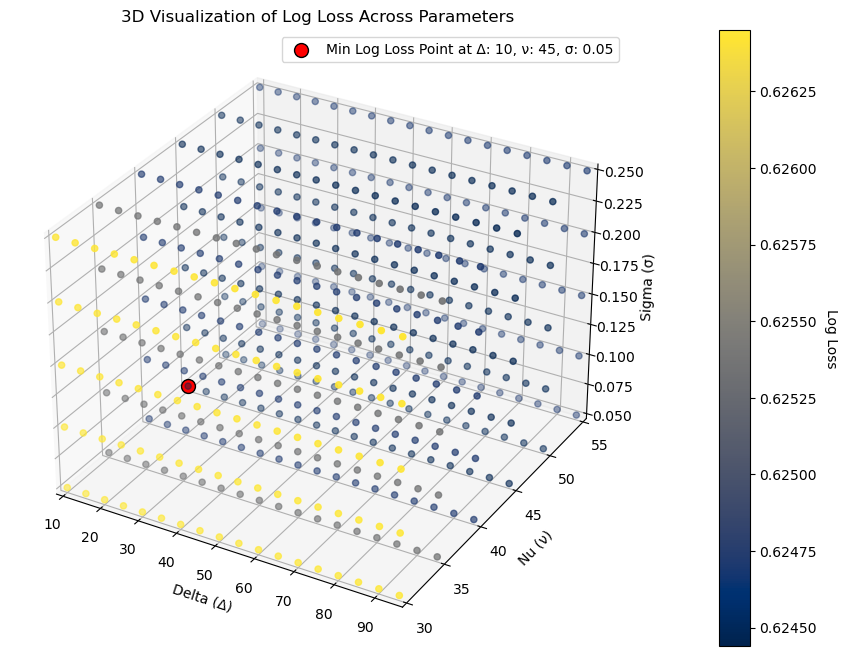

In [23]:
# Create a new figure for the 3D plot with a specified size
fig = plt.figure(figsize=(12, 8))

# Add a 3D subplot to the figure
ax = fig.add_subplot(111, projection='3d')

# Extract the delta, nu, and sigma values for the axes from the dataframe
X = results['delta']
Y = results['nu']
Z = results['sigma']

# Extract the log loss values to be used for coloring the scatter plot
log_loss_values = results['log_loss']

# Create a 3D scatter plot with delta, nu, and sigma as axes, and color-coded by log loss
sc = ax.scatter(X, Y, Z, c=log_loss_values, cmap='cividis', marker='o')

# Find the index of the minimum log loss value
min_loss_index = log_loss_values.idxmin()

# Extract the coordinates of the point with the minimum log loss
min_X = X[min_loss_index]
min_Y = Y[min_loss_index]
min_Z = Z[min_loss_index]

# Highlight the point with the minimum log loss in the scatter plot
ax.scatter(min_X, min_Y, min_Z, color='red', s=100, edgecolor='black', 
           label=f'Min Log Loss Point at Δ: {min_X}, ν: {min_Y}, σ: {min_Z}', zorder=5)

# Set the limits for each axis based on the data ranges
ax.set_xlim([X.min(), X.max()])
ax.set_ylim([Y.min(), Y.max()])
ax.set_zlim([Z.min(), Z.max()])

# Set the labels for each axis
ax.set_xlabel('Delta (Δ)')
ax.set_ylabel('Nu (ν)')
ax.set_zlabel('Sigma (σ)')

# Set the title for the plot
ax.set_title('3D Visualization of Log Loss Across Parameters')

# Add a legend to the plot
ax.legend()

# Add a color bar to the plot to indicate the scale of log loss values
cbar = plt.colorbar(sc, pad=0.1)  # Adjust padding to ensure it does not overlap with the plot
cbar.set_label('Log Loss', rotation=270, labelpad=15)

# Show the plot
plt.show()

### Best Metrics with minimum log loss 

#### For whole validation set

In [24]:
find_parameters_metrics_best_log_loss(results)

Best Parameters and Metrics with Minimum Log Loss:

Delta: 10.0000
Nu: 45.0000
Sigma: 0.0500
Accuracy: 0.6462
Calibration: 1.0202
Log Loss: 0.6244


#### For top 50 players

In [25]:
find_parameters_metrics_best_log_loss(results_top50)

Best Parameters and Metrics with Minimum Log Loss:

Delta: 10.0000
Nu: 45.0000
Sigma: 0.1000
Accuracy: 0.6665
Calibration: 1.0408
Log Loss: 0.6059


#### For top 100 players

In [26]:
find_parameters_metrics_best_log_loss(results_top100)

Best Parameters and Metrics with Minimum Log Loss:

Delta: 10.0000
Nu: 45.0000
Sigma: 0.0500
Accuracy: 0.6484
Calibration: 1.0275
Log Loss: 0.6229
